(anova2)=
# Factorial ANOVA

Over the course of the last few chapters you can probably detect a general trend. We started out looking at tools that you can use to compare two groups to one another, most notably the [$t$-test](ttest). Then, we introduced [analysis of variance](anova) (ANOVA) as a method for comparing more than two groups. The chapter on [regression](regression) covered a somewhat different topic, but in doing so it introduced a powerful new idea: building statistical models that have *multiple* predictor variables used to explain a single outcome variable. For instance, a regression model could be used to predict the number of errors a student makes in a reading comprehension test based on the number of hours they studied for the test, and their score on a standardised IQ test. The goal in this chapter is to import this idea into the ANOVA framework. For instance, suppose we were interested in using the reading comprehension test to measure student achievements in three different schools, and we suspect that girls and boys are developing at different rates (and so would be expected to have different performance on average). Each student is classified in two different ways: on the basis of their gender, and on the basis of their school. What we'd like to do is analyse the reading comprehension scores in terms of *both* of these grouping variables. The tool for doing so is generically referred to as **_factorial ANOVA_**. However, since we have two grouping variables, we sometimes refer to the analysis as a two-way ANOVA, in contrast to the one-way ANOVAs that we [ran earlier](anova).

(factorialanovasimple)=
## Balanced designs, main effects

When we discussed [analysis of variance](anova), we assumed a fairly simple experimental design: each person falls into one of several groups, and we want to know whether these groups have different means on some outcome variable. In this section, I'll discuss a broader class of experimental designs, known as **_factorial designs_**, in we have more than one grouping variable. I gave one example of how this kind of design might arise above. Another example appears in the chapter on [ANOVA](anova), in which we were looking at the effect of different drugs on the `mood_gain` experienced by each person. In that chapter we did find a significant effect of drug, but at the end of the chapter we also ran an analysis to see if there was an effect of therapy. We didn't find one, but there's something a bit worrying about trying to run two *separate* analyses trying to predict the same outcome. Maybe there actually *is* an effect of therapy on mood gain, but we couldn't find it because it was being "hidden" by the effect of drug? In other words, we're going to want to run a *single* analysis that includes *both* `drug` and `therapy` as predictors. For this analysis each person is cross-classified by the drug they were given (a factor with 3 levels) and what therapy they received (a factor with 2 levels). We refer to this as a $3 \times 2$ factorial design. If we cross-tabulate `drug` by `therapy` using the `crosstab()` in `pandas`, we get the following table:

In [211]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/ethanweed/pythonbook/main/Data/clintrial.csv")

pd.crosstab(index=df["drug"], columns=df["therapy"],margins=False)

therapy,CBT,no.therapy
drug,,
anxifree,3,3
joyzepam,3,3
placebo,3,3


As you can see, not only do we have participants corresponding to all possible combinations of the two factors, indicating that our design is **_completely crossed_**, it turns out that there are an equal number of people in each group. In other words, we have a **_balanced_** design. In this section I'll talk about how to analyse data from balanced designs, since this is the simplest case. The story for unbalanced designs is quite tedious, so we'll put it to one side for the moment.

(factanovahyp)=
### What hypotheses are we testing?

Like one-way ANOVA, factorial ANOVA is a tool for testing certain types of hypotheses about population means. So a sensible place to start would be to be explicit about what our hypotheses actually are. However, before we can even get to that point, it's really useful to have some clean and simple notation to describe the population means. Because of the fact that observations are cross-classified in terms of two different factors, there are quite a lot of different means that one might be interested. To see this, let's start by thinking about all the different sample means that we can calculate for this kind of design. Firstly, there's the obvious idea that we might be interested in this table of group means:

In [13]:
pd.DataFrame(round(df.groupby(by=['therapy', 'drug'])['mood_gain'].mean(),2)).reset_index()


,therapy,drug,mood_gain
0,CBT,anxifree,1.03
1,CBT,joyzepam,1.50
2,CBT,placebo,0.60
3,no.therapy,anxifree,0.40
4,no.therapy,joyzepam,1.47
5,no.therapy,placebo,0.30


Now, this output shows a cross-tabulation of the group means for all possible combinations of the two factors (e.g., people who received the placebo and no therapy, people who received the placebo while getting CBT, etc). However, we can also construct tables that ignore one of the two factors. That gives us output that looks like this:

In [14]:
pd.DataFrame(round(df.groupby(['therapy'])['mood_gain'].mean(),2)).reset_index()

,therapy,mood_gain
0,CBT,1.04
1,no.therapy,0.72


In [15]:
pd.DataFrame(round(df.groupby(['drug'])['mood_gain'].mean(),2)).reset_index()

,drug,mood_gain
0,anxifree,0.72
1,joyzepam,1.48
2,placebo,0.45


But of course, if we can ignore one factor we can certainly ignore both. That is, we might also be interested in calculating the average  mood gain across all 18 participants, regardless of what drug or psychological therapy they were given:

In [17]:
round(df['mood_gain'].mean(),2)

0.88

At this point we have 12 different sample means to keep track of! It is helpful to organise all these numbers into a single table, which would look like this:

|         |no therapy |CBT  |total |
|:--------|:----------|:----|:-----|
|placebo  |0.30       |0.60 |0.45  |
|anxifree |0.40       |1.03 |0.72  |
|joyzepam |1.47       |1.50 |1.48  |
|total    |0.72       |1.04 |0.88  |

Now, each of these different means is of course a sample statistic: it's a quantity that pertains to the specific observations that we've made during our study. What we want to make inferences about are the corresponding population parameters: that is, the true means as they exist within some broader population. Those population means can also be organised into a similar table, but we'll need a little mathematical notation to do so. As usual, I'll use the symbol $\mu$ to denote a population mean. However, because there are lots of different means, I'll need to use subscripts to distinguish between them. 

Here's how the notation works. Our table is defined in terms of two factors: each row corresponds to a different level of Factor A (in this case `drug`), and each column corresponds to a different level of Factor B (in this case `therapy`). If we let $R$ denote the number of rows in the table, and $C$ denote the number of columns, we can refer to this as an $R \times C$ factorial ANOVA. In this case $R=3$ and $C=2$. We'll use lowercase letters to refer to specific rows and columns, so $\mu_{rc}$ refers to the population mean associated with the $r$th level of Factor A (i.e. row number $r$) and the $c$th level of Factor B (column number $c$).[^notesubscript] So the population means are now written like this:

[^notesubscript]: The nice thing about the subscript notation is that generalises nicely: if our experiment had involved a third factor, then we could just add a third subscript. In principle, the notation extends to as many factors as you might care to include, but in this book we'll rarely consider analyses involving more than two factors, and never more than three. 

|         |no therapy |CBT        |total |
|:--------|:----------|:----------|:-----|
|placebo  |$\mu_{11}$ |$\mu_{12}$ |      |
|anxifree |$\mu_{21}$ |$\mu_{22}$ |      |
|joyzepam |$\mu_{31}$ |$\mu_{32}$ |      |
|total    |           |           |      |

Okay, what about the remaining entries? For instance, how should we describe the average mood gain across the entire (hypothetical) population of people who might be given Joyzepam in an experiment like this, regardless of whether they were in CBT? We use the "dot" notation to express this. In the case of Joyzepam, notice that we're talking about the mean associated with the third row in the table. That is, we're averaging across two cell means (i.e., $\mu_{31}$ and $\mu_{32}$). The result of this averaging is referred to as a **_marginal mean_**, and would be denoted $\mu_{3.}$ in this case. The marginal mean for CBT corresponds to the population mean associated with the second column in the table, so we use the notation $\mu_{.2}$ to describe it. The grand mean is denoted $\mu_{..}$ because it is the mean obtained by averaging (marginalising[^notemarginalising]) over both. So our full table of population means can be written down like this:

[^notemarginalising]: Technically, marginalising isn't quite identical to a regular mean: it's a weighted average, where you take into account the frequency of the different events that you're averaging over. However, in a balanced design, all of our cell frequencies are equal by definition, so the two are equivalent. We'll discuss unbalanced designs later, and when we do so you'll see that all of our calculations become a real headache. But let's ignore this for now.

|         |no therapy |CBT        |total      |
|:--------|:----------|:----------|:----------|
|placebo  |$\mu_{11}$ |$\mu_{12}$ |$\mu_{1.}$ |
|anxifree |$\mu_{21}$ |$\mu_{22}$ |$\mu_{2.}$ |
|joyzepam |$\mu_{31}$ |$\mu_{32}$ |$\mu_{3.}$ |
|total    |$\mu_{.1}$ |$\mu_{.2}$ |$\mu_{..}$ |

Now that we have this notation, it is straightforward to formulate and express some hypotheses. Let's suppose that the goal is to find out two things: firstly, does the choice of drug have any effect on mood, and secondly, does CBT have any effect on mood? These aren't the only hypotheses that we could formulate of course, and we'll see a really important example of a different kind of hypothesis in the section on [interactions](interactions), but these are the two simplest hypotheses to test, and so we'll start there. Consider the first test. If drug has no effect, then we would expect all of the row means to be identical, right? So that's our null hypothesis. On the other hand, if the drug does matter then we should expect these row means to be different. Formally, we write down our null and alternative hypotheses in terms of the *equality of marginal means*:

|                              |                                                             |
|:-----------------------------|:------------------------------------------------------------|
|Null hypothesis $H_0$:        |row means are the same i.e. $\mu_{1.} = \mu_{2.} = \mu_{3.}$ |
|Alternative hypothesis $H_1$: |at least one row mean is different.                          |

It's worth noting that these are *exactly* the same statistical hypotheses that we formed when we ran a one-way ANOVA on these data [way back when](anova). Back then I used the notation $\mu_P$ to refer to the mean mood gain for the placebo group, with $\mu_A$ and $\mu_J$ corresponding to the group means for the two drugs, and the null hypothesis was $\mu_P = \mu_A = \mu_J$. So we're actually talking about the same hypothesis: it's just that the more complicated ANOVA requires more careful notation due to the presence of multiple grouping variables, so we're now referring to this hypothesis as $\mu_{1.} = \mu_{2.} = \mu_{3.}$. However, as we'll see shortly, although the hypothesis is identical, the test of that hypothesis is subtly different due to the fact that we're now acknowledging the existence of the second grouping variable.

Speaking of the other grouping variable, you won't be surprised to discover that our second hypothesis test is formulated the same way. However, since we're talking about the psychological therapy rather than drugs, our null hypothesis now corresponds to the equality of the column means:


|                              |                                                          |
|:-----------------------------|:---------------------------------------------------------|
|Null hypothesis $H_0$:        |column means are the same, i.e., $\mu_{.1} = \mu_{.2}$    |
|Alternative hypothesis $H_1$: |column means are different, i.e., $\mu_{.1} \neq \mu_{.2}$|

### Running the analysis in Python

If the data you're trying to analyse correspond to a balanced factorial design, then running your analysis of variance is easy. To see how easy it is, let's start by reproducing the original analysis from [earlier](anova). In case you've forgotten, for that analysis we were using only a single factor (i.e., `drug`) as our between-subjects variable to predict our outcome (dependent) variable (i.e., `mood_gain`), and so this was what we did:

In [18]:
import pingouin as pg

model1 = pg.anova(dv='mood_gain', between='drug', data=df, detailed=True)
round(model1, 2)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,3.45,2,1.73,18.61,0.0,0.71
1,Within,1.39,15,0.09,NaN,NaN,NaN


Note that this time around I've used the name `model1` as the label for my `aov` object, since I'm planning on creating quite a few other models too. To start with, suppose I'm also curious to find out if `therapy` has a relationship to `mood_gain`. In light of what we've seen from our discussion of [multiple regression](regression), you probably won't be surprised that all we have to do is extend the formula: in other words, if we specify `dv=mood.gain, between=['drug', 'therapy']` as our model, we'll probably get what we're after:

In [25]:
model2 = pg.anova(dv='mood_gain', between=['drug', 'therapy'], data=df, detailed=True)
round(model2, 4)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,3.4533,2,1.7267,31.7143,0.0000,0.8409
1,therapy,0.4672,1,0.4672,8.5816,0.0126,0.4170
2,drug * therapy,0.2711,2,0.1356,2.4898,0.1246,0.2933
3,Residual,0.6533,12,0.0544,NaN,NaN,NaN


Most of this output is pretty simple to read too: the first row of the table reports a between-group sum of squares (SS) value associated with the `drug` factor, along with a corresponding between-group $df$ value. It also calculates a mean square value (MS), and $F$-statistic, an (uncorrected) $p$-value, and an estimate of the effect size (`np2`, that is, partial eta-squared). There is also a row corresponding to the `therapy` factor, and a row corresponding to the residuals (i.e., the within groups variation). 

Now, the third row is a little trickier, so let's just save that one for [later](interactions), shall we? (Spoiler: this is the interaction of `drug` and `therapy`, but we'll get there soon).

Not only are all of the individual quantities pretty familiar, the relationships between these different quantities has remained unchanged: just like we saw with the original one-way ANOVA, note that the mean square value is calculated by dividing SS by the corresponding $df$. That is, it's still true that

$$
\mbox{MS} = \frac{\mbox{SS}}{df}
$$



regardless of whether we're talking about `drug`, `therapy` or the residuals. To see this, let's not worry about how the sums of squares values are calculated: instead, let's take it on faith that Python has calculated the SS values correctly, and try to verify that all the rest of the numbers make sense. First, note that for the `drug` factor, we divide $3.45$ by $2$, and end up with a mean square value of $1.73$. For the `therapy` factor, there's only 1 degree of freedom, so our calculations are even simpler: dividing $0.47$ (the SS value) by 1 gives us an answer of $0.47$ (the MS value). 

Turning to the $F$ statistics and the $p$ values, notice that we have two of each: one corresponding to the `drug` factor and the other corresponding to the `therapy` factor. Regardless of which one we're talking about, the $F$ statistic is calculated by dividing the mean square value associated with the factor by the mean square value associated with the residuals. If we use "A" as shorthand notation to refer to the first factor (factor A; in this case `drug`) and "R" as shorthand notation to refer to the residuals, then the $F$ statistic associated with factor A is denoted $F_A$, and is calculated as follows:

$$
F_{A} = \frac{\mbox{MS}_{A}}{\mbox{MS}_{R}}
$$

Note that this use of "R" to refer to residuals is a bit awkward, since we also used the letter R to refer to the number of rows in the table, but I'm only going to use "R" to mean residuals in the context of SS$_R$ and MS$_R$, so hopefully this shouldn't be confusing. Anyway, to apply this formula to the  `drugs` factor, we take the mean square of $1.73$ and divide it by the residual mean square value of $0.07$, which gives us an $F$-statistic of $26.15$. The corresponding calculation for the `therapy` variable would be to divide $0.47$ by $0.07$ which gives $7.08$ as the $F$-statistic. Not surprisingly, of course, these are the same values that R has reported in the ANOVA table above.

The last part of the ANOVA table is the calculation of the $p$ values. Once again, there is nothing new here: for each of our two factors, what we're trying to do is test the null hypothesis that there is no relationship between the factor and the outcome variable (I'll be a bit more precise about this later on). To that end, we've (apparently) followed a similar strategy that we did in the one way ANOVA, and have calculated an $F$-statistic for each of these hypotheses. To convert these to $p$ values, all we need to do is note that the  that the sampling distribution for the $F$ *statistic* under the null hypothesis (that the factor in question is irrelevant) is an $F$ *distribution*: and that two degrees of freedom values are those corresponding to the factor, and those corresponding to the residuals. For the `drug` factor we're talking about an $F$ distribution with 2 and 14 degrees of freedom (I'll discuss degrees of freedom in more detail later). In contrast, for the `therapy` factor sampling distribution is $F$ with 1 and 14 degrees of freedom.

At this point, I hope you can see that the ANOVA table for this more complicated analysis corresponding to `model2` should be read in much the same way as the ANOVA table for the simpler analysis for `model1`. In short, it's telling us that the factorial ANOVA for our $3 \times 2$ design found a significant effect of drug ($F_{2,12} = 31.71, p < .001$) as well as a significant effect of therapy ($F_{1,12} = 8.58, p = .01$). Or, to use the more technically correct terminology, we would say that there are two **_main effects_** of drug and therapy. Why are these "main" effects? Well, because there could also be an *interaction* between the effect of `drug` and the effect of `therapy`. We'll explore the concept of [interactions](interactions) below.

In the previous section I had two goals: firstly, to show you that the Python commands needed to do factorial ANOVA are pretty much the same ones that we used for a one way ANOVA. The only difference is that we add to the number of predictors in the `between` argument of `pingouin`'s `anova()` function. Secondly, I wanted to show you what the ANOVA table looks like in this case, so that you can see from the outset that the basic logic and structure behind factorial ANOVA is the same as that which underpins one way ANOVA. Try to hold onto that feeling. It's genuinely true, insofar as factorial ANOVA is built in more or less the same way as the simpler one-way ANOVA model. It's just that this feeling of familiarity starts to evaporate once you start digging into the details. Traditionally, this comforting sensation is replaced by an urge to murder the the authors of statistics textbooks.

Okay, let's start looking at some of those details. The explanation that I gave in the last section illustrates the fact that the hypothesis tests for the main effects (of drug and therapy in this case) are $F$-tests, but what it doesn't do is show you how the sum of squares (SS) values are calculated. Nor does it tell you explicitly how to calculate degrees of freedom ($df$ values) though that's a simple thing by comparison. Let's assume for now that we have only two predictor variables, Factor A and Factor B. If we use $Y$ to refer to the outcome variable, then we would use $Y_{rci}$ to refer to the outcome associated with the $i$-th member of group $rc$ (i.e., level/row $r$ for Factor A and level/column $c$ for Factor B). Thus, if we use $\bar{Y}$ to refer to a sample mean, we can use the same notation as before to refer to group means, marginal means and grand means: that is, $\bar{Y}_{rc}$ is the sample mean associated with the $r$th level of Factor A and the $c$th level of Factor B, $\bar{Y}_{r.}$ would be the marginal mean for the $r$th level of Factor A, $\bar{Y}_{.c}$ would be the marginal mean for the $c$th level of Factor B, and $\bar{Y}_{..}$ is the grand mean. In other words, our sample means can be organised into the same table as the population means. For our clinical trial data, that table looks like this:

|         |no therapy     |CBT            |total          |
|:--------|:--------------|:--------------|:--------------|
|placebo  |$\bar{Y}_{11}$ |$\bar{Y}_{12}$ |$\bar{Y}_{1.}$ |
|anxifree |$\bar{Y}_{21}$ |$\bar{Y}_{22}$ |$\bar{Y}_{2.}$ |
|joyzepam |$\bar{Y}_{31}$ |$\bar{Y}_{32}$ |$\bar{Y}_{3.}$ |
|total    |$\bar{Y}_{.1}$ |$\bar{Y}_{.2}$ |$\bar{Y}_{..}$ |

And if we look at the sample means that I showed earlier, we have $\bar{Y}_{11} = 0.30$, $\bar{Y}_{12} = 0.60$ etc. In our clinical trial example, the `drugs` factor has 3 levels and the `therapy` factor has 2 levels, and so what we're trying to run is a $3 \times 2$ factorial ANOVA. However, we'll be a little more general and say that Factor A (the row factor) has $R$ levels and Factor B (the column factor) has $C$ levels, and so what we're runnning here is an $R \times C$ factorial ANOVA.

Now that we've got our notation straight, we can compute the sum of squares values for each of the two factors in a relatively familiar way. For Factor A, our between group sum of squares is calculated by assessing the extent to which the (row) marginal means $\bar{Y}_{1.}$, $\bar{Y}_{2.}$ etc, are different from the grand mean $\bar{Y}_{..}$. We do this in the same way that we did for one-way ANOVA: calculate the sum of squared difference between the $\bar{Y}_{i.}$ values and the $\bar{Y}_{..}$ values. Specifically, if there are $N$ people in each group, then we calculate this:

$$
\mbox{SS}_{A} = (N \times C)  \sum_{r=1}^R  \left( \bar{Y}_{r.} - \bar{Y}_{..} \right)^2
$$

As with one-way ANOVA, the most interesting [^translation] part of this formula is the $\left( \bar{Y}_{r.} - \bar{Y}_{..} \right)^2$ bit, which corresponds to the squared deviation associated with level $r$. All that this formula does is calculate this squared deviation for all $R$ levels of the factor, add them up, and then multiply the result by $N \times C$. The reason for this last part is that there are multiple cells in our design that have level $r$ on Factor A: in fact, there are $C$ of them, one corresponding to each possible level of Factor B! For instance, in our toy example, there are *two* different cells in the design corresponding to the `anxifree` drug: one for people with `no.therapy`, and one for the `CBT` group. Not only that, within each of these cells there are $N$ observations. So, if we want to convert our SS value into a quantity that calculates the between-groups sum of squares on a "per observation" basis, we have to multiply by by $N \times C$. The formula for factor B is of course the same thing, just with some subscripts shuffled around:

$$
\mbox{SS}_{B} = (N \times R) \sum_{c=1}^C \left( \bar{Y}_{.c} - \bar{Y}_{..} \right)^2
$$

[^translation]: English translation: "least tedious".

Now that we have these formulas, we can check them against the `pingouin` output from the earlier section. First, notice that we calculated all the marginal means (i.e., row marginal means $\bar{Y}_{r.}$ and column marginal means $\bar{Y}_{.c}$) earlier using `.mean()`, and we also calculated the grand mean. Let's repeat those calculations, but this time we'll save the results to variables so that we can use them in subsequent calculations:

In [65]:
drug_means = df.groupby(['drug'])['mood_gain'].mean()
therapy_means = df.groupby(['therapy'])['mood_gain'].mean()
grand_mean = df['mood_gain'].mean()

Okay, now let’s calculate the sum of squares associated with the main effect of drug. There are a total of $N=3$ people in each group, and $C=2$ different types of therapy. Or, to put it another way, there are $3 \times 2 = 6$ people who received any particular drug. So our calculations are:

In [63]:
SS_drug = (3*2) * sum((drug_means - grand_mean)**2)
round(SS_drug,4)

3.4533

Not surprisingly, this is the same number that you get when you look up the SS value for the drugs factor in the ANOVA table that I presented earlier. We can repeat the same kind of calculation for the effect of therapy. Again there are $N=3$ people in each group, but since there are $R=3$ different drugs, this time around we note that there are $3 \times 3 = 9$ people who received CBT, and an additional 9 people who received the placebo. So our calculation is now:

In [69]:
SS_therapy = (3*3) * sum((therapy_means - grand_mean)**2)
round(SS_therapy,4)

0.4672

and we are, once again, unsurprised to see that our calculations are identical to the ANOVA output.

So that's how you calculate the SS values for the two main effects. These SS values are analogous to the between-group sum of squares values that we calculated when doing [one-way ANOVA](anova). However, it's not a good idea to think of them as between-groups SS values anymore, just because we have two different grouping variables and it's easy to get confused. In order to construct an $F$ test, however, we also need to calculate the within-groups sum of squares. In keeping with the terminology that we used in the [regression chapter](regression)) and the terminology that R uses when printing out the ANOVA table, I'll start referring to the within-groups SS value as the *residual* sum of squares SS$_R$. 

The easiest way to think about the residual SS values in this context, I think, is to think of it as the leftover variation in the outcome variable after you take into account the differences in the marginal means (i.e., after you remove SS$_A$ and SS$_B$). What I mean by that is we can start by calculating the total sum of squares, which I'll label SS$_T$. The formula for this is pretty much the same as it was for one-way ANOVA: we take the difference between each observation $Y_{rci}$ and the grand mean $\bar{Y}_{..}$, square the differences, and add them all up

$$
\mbox{SS}_T = \sum_{r=1}^R \sum_{c=1}^C \sum_{i=1}^N \left( Y_{rci} - \bar{Y}_{..}\right)^2
$$

The "triple summation" here looks more complicated than it is. In the first two summations, we're summing across all levels of Factor A (i.e., over all possible rows $r$ in our table), across all levels of Factor B (i.e., all possible columns $c$). Each $rc$ combination corresponds to a single group, and each group contains $N$ people: so we have to sum across all those people (i.e., all $i$ values) too. In other words, all we're doing here is summing across all observations in the data set (i.e., all possible $rci$ combinations). 

At this point, we know the total variability of the outcome variable SS$_T$, and we know how much of that variability can be attributed to Factor A (SS$_A$) and how much of it can be attributed to Factor B (SS$_B$). The residual sum of squares is thus defined to be the variability in $Y$ that *can't* be attributed to either of our two factors. In other words:

$$
\mbox{SS}_R = \mbox{SS}_T - (\mbox{SS}_A + \mbox{SS}_B)
$$

Of course, there is a formula that you can use to calculate the residual SS directly, but I think that it makes more conceptual sense to think of it like this. The whole point of calling it a residual is that it's the leftover variation, and the formula above makes that clear. I should also note that, in keeping with the terminology used in the regression chapter, it is commonplace to refer to $\mbox{SS}_A + \mbox{SS}_B$ as the variance attributable to the "ANOVA model", denoted SS$_M$, and so we often say that the total sum of squares is equal to the model sum of squares plus the residual sum of squares. Later on in this chapter we'll see that this isn't just a surface similarity: ANOVA and regression are actually the same thing under the hood. 

In any case, it's probably worth taking a moment to check that we can calculate SS$_R$ using this formula, and verify that we do obtain the same answer that `pingouin` produces in its ANOVA table. The calculations are pretty straightforward. First we calculate the total sum of squares:

In [72]:
SS_tot = sum((df['mood_gain'] - grand_mean)**2)
round(SS_tot,4)

4.845

and then we use it to calculate the residual sum of squares:

In [73]:
SS_res = SS_tot - (SS_drug + SS_therapy)
round(SS_res,4)

0.9244

Yet again, we get the same answer. 

### What are our degrees of freedom?

The degrees of freedom are calculated in much the same way as for one-way ANOVA. For any given factor, the degrees of freedom is equal to the number of levels minus 1 (i.e., $R-1$ for the row variable, Factor A, and $C-1$ for the column variable, Factor B). So, for the `drugs` factor we obtain $df = 2$, and for the `therapy` factor we obtain $df=1$. Later on on, when we discuss the interpretation of [ANOVA as a regression model](anovalm)), I'll give a clearer statement of how we arrive at this number, but for the moment we can use the simple definition of degrees of freedom, namely that the degrees of freedom equals the number of quantities that are observed, minus the number of constraints. So, for the `drugs` factor, we observe 3 separate group means, but these are constrained by 1 grand mean; and therefore the degrees of freedom is 2. For the residuals, the logic is similar, but not quite the same. The total number of observations in our experiment is 18. The constraints correspond to the 1 grand mean, the 2 additional group means that the `drug` factor introduces, and the 1 additional group mean that the the `therapy` factor introduces, and so our degrees of freedom is 14. As a formula, this is $N-1 -(R-1)-(C-1)$, which simplifies to $N-R-C+1$.

### Factorial ANOVA versus one-way ANOVAs

Now that we've seen *how* a factorial ANOVA works, it's worth taking a moment to compare it to the results of the one way analyses, because this will give us a really good sense of *why* it's a good idea to run the factorial ANOVA. In the [chapter on 1-way ANOVA](anova), I ran a one-way ANOVA that looked to see if there are any differences between drugs, and a second one-way ANOVA to see if there were any differences between therapies. As we saw in [previously](factanovahyp), the null and alternative hypotheses tested by the one-way ANOVAs are in fact identical to the hypotheses tested by the factorial ANOVA. Looking even more carefully at the ANOVA tables, we can see that the sum of squares associated with the factors are identical in the two different analyses (3.45 for `drug` and 0.92 for `therapy`), as are the degrees of freedom (2 for `drug`, 1 for `therapy`). But they don't give the same answers! Most notably, when we ran the [one-way ANOVA for `therapy`](anovaandt) we didn't find a significant effect (the $p$-value was 0.21). However, when we look at the main effect of `therapy` within the context of the two-way ANOVA, we do get a significant effect ($p=.019$). The two analyses are clearly not the same.

Why does that happen? The answer lies in understanding how the *residuals* are calculated. Recall that the whole idea behind an $F$-test is to compare the variability that can be attributed to a particular factor with the variability that cannot be accounted for (the residuals). If you run a one-way ANOVA for `therapy`, and therefore ignore the effect of `drug`, the ANOVA will end up dumping all of the drug-induced variability into the residuals! This has the effect of making the data look more noisy than they really are, and the effect of `therapy` which is correctly found to be significant in the two-way ANOVA now becomes non-significant. If we ignore something that actually matters (e.g., `drug`) when trying to assess the contribution of something else (e.g., `therapy`) then our analysis will be distorted. Of course, it's perfectly okay to ignore variables that are genuinely irrelevant to the phenomenon of interest: if we had recorded the colour of the walls, and that turned out to be non-significant in a three-way ANOVA (i.e. `pg.anova(dv='mood_gain', between=['drug', 'therapy', 'wall_color']`), it would be perfectly okay to disregard it and just report the simpler two-way ANOVA that doesn't include this irrelevant factor. What you shouldn't do is drop variables that actually make a difference! 

### What kinds of outcomes does this analysis capture?

The ANOVA model that we've been talking about so far covers a range of different patterns that we might observe in our data. For instance, in a two-way ANOVA design, there are four possibilities: (a) only Factor A matters, (b) only Factor B matters, (c) both A and B matter, and (d) neither A nor B matters. An example of each of these four possibilities is plotted in {numref}`fig-anovas-sans-interaction`. 


In [169]:
import seaborn as sns
from matplotlib import pyplot as plt

levels = ['Level 1', 'Level 1', 'Level 2', 'Level 2']
factors = ['Factor B, Level 1', 'Factor B, Level 2', 'Factor B, Level 1', 'Factor B, Level 2']
panel1 = [1,1.2,2,2.2]
panel2 = [1.2, 1.9, 1.2, 1.9]
panel3 = [0.6, 1.4, 1.5, 2.4]
panel4 = [1.5, 1.6, 1.5, 1.6]

d = pd.DataFrame({'Factor': factors,
                   'Factor A': levels,
                   'Panel 1': panel1,
                   'Panel 2': panel2,
                   'Panel 3': panel3,
                   'Panel 4': panel4})

fig, axes = plt.subplots(2,2)


p1 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 1', hue= 'Factor', errorbar=('ci', False), ax=axes[0,0])
p2 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 2', hue= 'Factor', errorbar=('ci', False), ax=axes[0,1])
p3 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 3', hue= 'Factor', errorbar=('ci', False), ax=axes[1,0])
p4 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 4', hue= 'Factor', errorbar=('ci', False), ax=axes[1,1])

ps = [p1, p2, p3, p4]
panelID = ['A', 'B', 'C', 'D']
titles = ['Only Factor A has an effect', 'Only Factor B has an effect', 
          'Both A and B have an effect', 'Neither A nor B has an effect']

for n, p in enumerate(ps):
    p.set_ylim(0,3)
    p.set_ylabel('')
    p.set_xlabel('')
    p.get_legend().remove()
    p.text(0.1, 1, titles[n], horizontalalignment='left', verticalalignment='top', transform=p.transAxes)
    p.text(0, 1.1, panelID[n], horizontalalignment='left', verticalalignment='top', transform=p.transAxes)
    sns.despine()

p1.set_xticklabels('')
p2.set_xticklabels('')

p3.set_xlabel('Factor A')
p4.set_xlabel('Factor A')

handles, labels = p1.get_legend_handles_labels()
fig.legend(handles, ['Factor B, Level 1', 'Factor B, Level 2'], loc='upper center', ncol=2)


# Plot figure in book, with caption
from myst_nb import glue
plt.close(fig)
glue("anovas-sans-interaction-fig", fig, display=False)

 ```{glue:figure} anovas-sans-interaction-fig
:figwidth: 600px
:name: fig-anovas-sans-interaction

The four different outcomes for a 2 x 2 ANOVA when no interactions are present. In Panel A we see a main effect of Factor A, and no effect of Factor B. Panel B shows a main effect of Factor B but no effect of Factor A. Panel C shows main effects of both Factor A and Factor B. Finally, Panel D shows no effect of either factor.

```


(interactions)=
## Balanced designs, main effects and interactions

The four patterns of data shown in {numref}`anovas-sans-interaction-fig` are all quite realistic: there are a great many data sets that produce exactly those patterns. However, they are not the whole story, and the ANOVA model that we have been talking about up to this point is not sufficient to fully account for a table of group means. Why not? Well, so far we have the ability to talk about the idea that drugs can influence mood, and therapy can influence mood, but no way of talking about the possibility of an **_interaction_** between the two. An interaction between A and B is said to occur whenever the effect of Factor A is *different*, depending on which level of Factor B we're talking about. Several examples of an interaction effect with the context of a 2 x 2 ANOVA are shown in {numref}`fig-anovas-avec-interaction`. To give a more concrete example, suppose that the operation of Anxifree and Joyzepam is governed quite different physiological mechanisms, and one consequence of this is that while Joyzepam has more or less the same effect on mood regardless of whether one is in therapy, Anxifree is actually much more effective when administered in conjunction with CBT. The ANOVA that we developed in the previous section does not capture this idea. To get some idea of whether an interaction is actually happening here, it helps to plot the various group means.

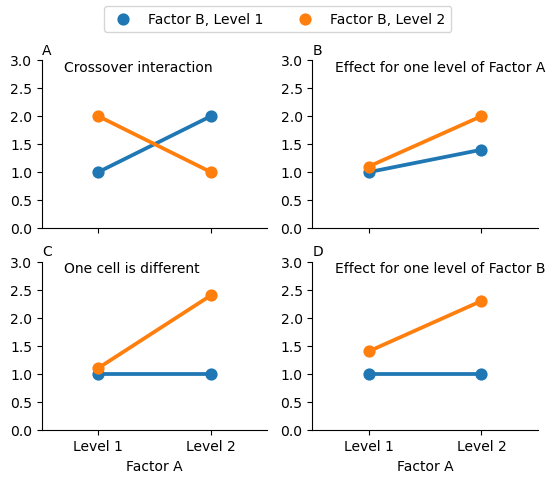

In [174]:
import seaborn as sns
from matplotlib import pyplot as plt

levels = ['Level 1', 'Level 1', 'Level 2', 'Level 2']
factors = ['Factor B, Level 1', 'Factor B, Level 2', 'Factor B, Level 1', 'Factor B, Level 2']
panel1 = [1,2,2,1]
panel2 = [1, 1.1, 1.4, 2]
panel3 = [1, 1.1, 1, 2.4]
panel4 = [1, 1.4, 1, 2.3]

d = pd.DataFrame({'Factor': factors,
                   'Factor A': levels,
                   'Panel 1': panel1,
                   'Panel 2': panel2,
                   'Panel 3': panel3,
                   'Panel 4': panel4})

fig, axes = plt.subplots(2,2)


p1 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 1', hue= 'Factor', errorbar=('ci', False), ax=axes[0,0])
p2 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 2', hue= 'Factor', errorbar=('ci', False), ax=axes[0,1])
p3 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 3', hue= 'Factor', errorbar=('ci', False), ax=axes[1,0])
p4 = sns.pointplot(data = d, x = 'Factor A', y = 'Panel 4', hue= 'Factor', errorbar=('ci', False), ax=axes[1,1])

ps = [p1, p2, p3, p4]
panelID = ['A', 'B', 'C', 'D']
titles = ['Crossover interaction', 'Effect for one level of Factor A', 
          'One cell is different', 'Effect for one level of Factor B']

for n, p in enumerate(ps):
    p.set_ylim(0,3)
    p.set_ylabel('')
    p.set_xlabel('')
    p.get_legend().remove()
    p.text(0.1, 1, titles[n], horizontalalignment='left', verticalalignment='top', transform=p.transAxes)
    p.text(0, 1.1, panelID[n], horizontalalignment='left', verticalalignment='top', transform=p.transAxes)
    sns.despine()

p1.set_xticklabels('')
p2.set_xticklabels('')

p3.set_xlabel('Factor A')
p4.set_xlabel('Factor A')

handles, labels = p1.get_legend_handles_labels()
fig.legend(handles, ['Factor B, Level 1', 'Factor B, Level 2'], loc='upper center', ncol=2)


# Plot figure in book, with caption
from myst_nb import glue
plt.close(fig)
glue("anovas-avec-interaction-fig", fig, display=False)

 ```{glue:figure} anovas-avec-interaction-fig
:figwidth: 600px
:name: fig-anovas-avec-interaction

Qualitatively different interactions for a 2 x 2 ANOVA

```


To give a more concrete example, suppose that the operation of Anxifree and Joyzepam is governed quite different physiological mechanisms, and one consequence of this is that while Joyzepam has more or less the same effect on mood regardless of whether one is in therapy, Anxifree is actually much more effective when administered in conjunction with CBT. The ANOVA that we developed in the previous section does not capture this idea. To get some idea of whether an interaction is actually happening here, it helps to plot the various group means. We can do this easily with `seaborn`:

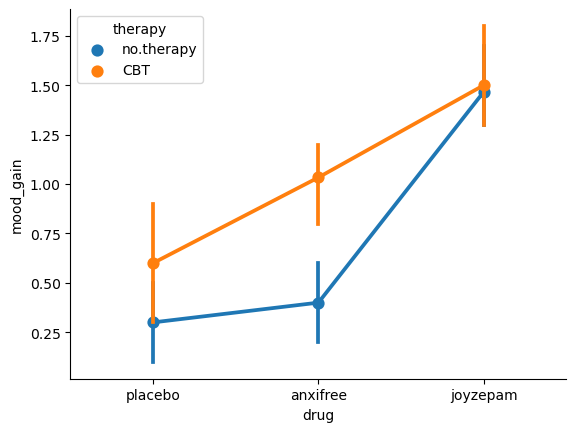

In [178]:
sns.pointplot(data=df, x='drug', y='mood_gain', hue='therapy')
sns.despine()

Our main concern relates to the fact that the two lines aren't parallel. The effect of CBT (difference between solid line and dotted line) when the drug is Joyzepam (right side) appears to be near zero, even smaller than the effect of CBT when a placebo is used (left side). However, when Anxifree is administered, the effect of CBT is larger than the placebo (middle). Is this effect real, or is this just random variation due to chance? Our original ANOVA cannot answer this question, because we make no allowances for the idea that interactions even exist! In this section, we'll fix this problem.


### What exactly *is* an interaction effect?

The key idea that we're going to introduce in this section is that of an interaction effect. `pingouin` has already been calculating the for us, but to keep things simple, I have just ignored them. Now the time has come to look at that _other_ line in the ANOVA table, the one that about "drug*therapy".

Intuitively, the idea behind an interaction effect is fairly simple: it just means that the effect of Factor A is different, depending on which level of Factor B we're talking about. But what does that actually mean in terms of our data? {numref}`fig-anovas-avec-interaction` depicts several different patterns that, although quite different to each other, would all count as an interaction effect. So it's not entirely straightforward to translate this qualitative idea into something mathematical that a statistician can work with. As a consequence, the way that the idea of an interaction effect is formalised in terms of null and alternative hypotheses is slightly difficult, and I'm guessing that a lot of readers of this book probably won't be all that interested. Even so, I'll try to give the basic idea here.

To start with, we need to be a little more explicit about our main effects. Consider the main effect of Factor A (`drug` in our running example). We originally formulated this in terms of the null hypothesis that the two marginal means $\mu_{r.}$ are all equal to each other. Obviously, if all of these are equal to each other, then they must also be equal to the grand mean $\mu_{..}$ as well, right? So what we can do is define the *effect* of Factor A at level $r$ to be equal to the difference between the marginal mean $\mu_{r.}$ and the grand mean $\mu_{..}$.  

Let's denote this effect by $\alpha_r$, and note that

$$
\alpha_r  = \mu_{r.} - \mu_{..} 
$$

Now, by definition all of the $\alpha_r$ values must sum to zero, for the same reason that the average of the marginal means $\mu_{r.}$ must be the grand mean $\mu_{..}$. We can similarly define the effect of Factor B at level $i$ to be the difference between the column marginal mean $\mu_{.c}$ and the grand mean $\mu_{..}$

$$
\beta_c = \mu_{.c} - \mu_{..}
$$

and once again, these $\beta_c$ values must sum to zero. The reason that statisticians sometimes like to talk about the main effects in terms of these $\alpha_r$ and $\beta_c$ values is that it allows them to be precise about what it means to say that there is no interaction effect. If there is no interaction at all, then these $\alpha_r$ and $\beta_c$ values will perfectly describe the group means $\mu_{rc}$. Specifically, it means that

$$
\mu_{rc} = \mu_{..} + \alpha_r + \beta_c 
$$

That is, there's nothing *special* about the group means that you couldn't predict perfectly by knowing all the marginal means. And that's our null hypothesis, right there. The alternative hypothesis is that

$$
\mu_{rc} \neq \mu_{..} + \alpha_r + \beta_c 
$$

for at least one group $rc$ in our table. However, statisticians often like to write this slightly differently. They'll usually define the specific interaction associated with group $rc$ to be some number, awkwardly referred to as $(\alpha\beta)_{rc}$, and then they will say that the alternative hypothesis is that 

$$
\mu_{rc} = \mu_{..} + \alpha_r + \beta_c + (\alpha\beta)_{rc}
$$

where $(\alpha\beta)_{rc}$ is non-zero for at least one group. This notation is kind of ugly to look at, but it is handy as we'll see in the next section when discussing how to calculate the sum of squares.


### Calculating sums of squares for the interaction

How should we calculate the sum of squares for the interaction terms, SS$_{A:B}$? 

Well, first off, it helps to notice how the previous section defined the interaction effect in terms of the extent to which the actual group means differ from what you'd expect by just looking at the marginal means. Of course, all of those formulas refer to population parameters rather than sample statistics, so we don't actually know what they are. However, we can estimate them by using sample means in place of population means. So for Factor A, a good way to estimate the main effect at level $r$ as the difference between the *sample* marginal mean $\bar{Y}_{rc}$ and the sample grand mean $\bar{Y}_{..}$. That is, we would use this as our estimate of the effect:

$$
\hat{\alpha}_r = \bar{Y}_{r.} - \bar{Y}_{..}
$$

Similarly, our estimate of the main effect of Factor B at level $c$ can be defined as follows:

$$
\hat{\beta}_c = \bar{Y}_{.c} - \bar{Y}_{..}
$$

Now, if you go back to the formulas that I used to describe the SS values for the two main effects, you'll notice that these effect terms are exactly the quantities that we were squaring and summing! So what's the analog of this for interaction terms? The answer to this can be found by first rearranging the formula for the group means $\mu_{rc}$ under the alternative hypothesis, so that we get this:

$$
\begin{align}
(\alpha \beta)_{rc} &= \mu_{rc} - \mu_{..} - \alpha_r - \beta_c \\
                &= \mu_{rc} - \mu_{..} - (\mu_{r.} - \mu_{..}) - (\mu_{.c} - \mu_{..}) \\
                & =  \mu_{rc} - \mu_{r.} - \mu_{.c} + \mu_{..}
\end{align}
$$



So, once again, if we substitute our sample statistics in place of the population means, we get the following as our estimate of the interaction effect for group $rc$, which is

$$
\hat{(\alpha\beta)}_{rc} = \bar{Y}_{rc} - \bar{Y}_{r.} - \bar{Y}_{.c} + \bar{Y}_{..}
$$

Now all we have to do is sum all of these estimates across all $R$ levels of Factor A and all $C$ levels of Factor B, and we obtain the following formula for the sum of squares associated with the interaction as a whole:

$$
\mbox{SS}_{A:B} = N \sum_{r=1}^R \sum_{c=1}^C \left( \bar{Y}_{rc} - \bar{Y}_{r.} - \bar{Y}_{.c} + \bar{Y}_{..} \right)^2
$$

where, we multiply by $N$ because there are $N$ observations in each of the groups, and we want our SS values to reflect the variation among *observations* accounted for by the interaction, not the variation among groups. 


Now that we have a formula for calculating SS$_{A:B}$, it's important to recognise that the interaction term is part of the model (of course), so the total sum of squares associated with the model, SS$_M$ is now equal to the sum of the three relevant SS values, $\mbox{SS}_A + \mbox{SS}_B + \mbox{SS}_{A:B}$. The residual sum of squares $\mbox{SS}_R$ is still defined as the leftover variation, namely $\mbox{SS}_T - \mbox{SS}_M$, but now that we have the interaction term this becomes

$$
\mbox{SS}_R = \mbox{SS}_T - (\mbox{SS}_A + \mbox{SS}_B + \mbox{SS}_{A:B})
$$ 


As a consequence, the residual sum of squares SS$_R$ will be smaller than in our original ANOVA that didn't include interactions.



### Degrees of freedom for the interaction

Calculating the degrees of freedom for the interaction is, once again, slightly trickier than the corresponding calculation for the main effects. To start with, let's think about the ANOVA model as a whole. Once we include interaction effects in the model, we're allowing every single group to have a unique mean, $\mu_{rc}$. For an $R \times C$ factorial ANOVA, this means that there are $R \times C$ quantities of interest in the model, and only the one constraint: all of the group means need to average out to the grand mean. So the model as a whole needs to have $(R\times C) - 1$ degrees of freedom. But the main effect of Factor A has $R-1$ degrees of freedom, and the main effect of Factor B has $C-1$ degrees of freedom. Which means that the degrees of freedom associated with the interaction is 

$$
\begin{align}
df_{A:B} &= (R\times C - 1) - (R - 1) - (C -1 ) \\
        &= RC - R - C + 1 \\
        &= (R-1)(C-1)
\end{align}
$$

which is just the product of the degrees of freedom associated with the row factor and the column factor.

What about the residual degrees of freedom? Because we've added interaction terms, which absorb some degrees of freedom, there are fewer residual degrees of freedom left over. Specifically, note that if the model with interaction has a total of $(R\times C) - 1$, and there are $N$ observations in your data set that are constrained to satisfy 1 grand mean, your residual degrees of freedom now become $N-(R \times C)-1+1$, or just $N-(R \times C)$.

### Interpreting the results

Now we are in a position to understand all the rows in the ANOVA table that we saw earlier. Even if you skimmed lightly over the math in the previous section (and you would be forgiven if you did), hopefully you will now have some intuition for the differences between main effects and interaction effects. But what does it all mean, in the end?

Let's quickly remind ourselves of the results of our factorial ANOVA:

In [180]:
model2 = pg.anova(dv='mood_gain', between=['drug', 'therapy'], data=df, detailed=True)
round(model2, 3)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,3.453,2,1.727,31.714,0.000,0.841
1,therapy,0.467,1,0.467,8.582,0.013,0.417
2,drug * therapy,0.271,2,0.136,2.490,0.125,0.293
3,Residual,0.653,12,0.054,NaN,NaN,NaN


We can now see that while we do have a significant main effect of drug ($F_{2,12} = 31.7, p <.001$) and therapy type ($F_{1,12} = 8.6, p=.013$), there is no significant interaction between the two ($F_{2,12} = 2.5, p = 0.125$).

There's a couple of very important things to consider when interpreting the results of factorial ANOVA. Firstly, there's the same issue that we had with one-way ANOVA, which is that if you obtain a significant main effect of (say) `drug`, it doesn't tell you anything about which drugs are different to one another. To find that out, you need to run additional analyses. We'll talk about some analyses that you can run in the sections on [contrasts](contrasts) and [post-hoc tests](posthoc2). The same is true for interaction effects: knowing that there's a significant interaction doesn't tell you anything about what kind of interaction exists. Again, you'll need to run additional analyses. 

Secondly, there's a very peculiar interpretation issue that arises when you obtain a significant interaction effect but no corresponding main effect. This happens sometimes. For instance, in the crossover interaction shown in {numref}`fig-anovas-avec-interaction`), this is exactly what you'd find: in this case, neither of the main effects would be significant, but the interaction effect would be. This is a difficult situation to interpret, and people often get a bit confused about it. The general advice that statisticians like to give in this situation is that you shouldn't pay much attention to the main effects when an interaction is present. The reason they say this is that, although the tests of the main effects are perfectly valid from a mathematical point of view, when there is a significant interaction effect, the main effects rarely test interesting hypotheses. [Recall](factanovahyp) that the null hypothesis for a main effect is that the *marginal means* are equal to each other, and that a marginal mean is formed by averaging across several different groups. But if you have a significant interaction effect, then you *know* that the groups that comprise the marginal mean aren't homogeneous, so it's not really obvious why you would even care about those marginal means. 

Here's what I mean. Again, let's stick with a clinical example. Suppose that we had a $2 \times 2$ design comparing two different treatments for phobias (e.g., systematic desensitisation vs flooding), and two different anxiety reducing drugs (e.g., Anxifree vs Joyzepam). Now suppose what we found was that Anxifree had no effect when desensitisation was the treatment, and Joyzepam had no effect when flooding was the treatment. But both were pretty effective for the other treatment. This is a classic crossover interaction, and what we'd find when running the ANOVA is that there is no main effect of drug, but a significant interaction. Now, what does it actually *mean* to say that there's no main effect? Well, it means that, if we average over the two different psychological treatments, then the *average* effect of Anxifree and Joyzepam is the same. But why would anyone care about that? When treating someone for phobias, it is never the case that a person can be treated using an "average" of flooding and desensitisation: that doesn't make a lot of sense. You either get one or the other. For one treatment, one drug is effective; and for the other treatment, the other drug is effective. The interaction is the important thing; the main effect is kind of irrelevant. 

This sort of thing happens a lot: the main effect are tests of marginal means, and when an interaction is present we often find ourselves not being terribly interested in marginal means, because they imply averaging over things that the interaction tells us shouldn't be averaged! Of course, it's not always the case that a main effect is meaningless when an interaction is present. Often you can get a big main effect and a very small interaction, in which case you can still say things like "drug A is generally more effective than drug B" (because there was a big effect of drug), but you'd need to modify it a bit by adding that "the difference in effectiveness was different for different psychological treatments". In any case, the main point here is that whenever you get a significant interaction you should stop and *think* about what the main effect actually means in this context. Don't automatically assume that the main effect is interesting. 

### Effect sizes

The effect size calculations for a factorial ANOVA is pretty similar to [those used in one way ANOVA](etasquared). Specifically, we can use $\eta^2$ (eta-squared) as simple way to measure how big the overall effect is for any particular term. As before, $\eta^2$ is defined by dividing the sum of squares associated with that term by the total sum of squares. For instance, to determine the size of the main effect of Factor A, we would use the following formula

$$
\eta_A^2 = \frac{\mbox{SS}_{A}}{\mbox{SS}_{T}}
$$

As before, this can be interpreted in much the same way as $R^2$ in regression.[^R]  It tells you the proportion of variance in the outcome variable that can be accounted for by the main effect of Factor A. It is therefore a number that ranges from 0 (no effect at all) to 1 (accounts for *all* of the variability in the outcome). Moreover, the sum of all the $\eta^2$ values, taken across all the terms in the model, will sum to the the total $R^2$ for the ANOVA model. If, for instance, the ANOVA model fits perfectly (i.e., there is no within-groups variability at all!), the $\eta^2$ values will sum to 1. Of course, that rarely if ever happens in real life.

However, when doing a factorial ANOVA, there is a second measure of effect size that people like to report, known as partial $\eta^2$. This is the effect size measure that `pingouin` gives you by default. The idea behind partial $\eta^2$ (which is sometimes denoted $_p\eta^2$ or $\eta^2_p$) is that, when measuring the effect size for a particular term (say, the main effect of Factor A), you want to deliberately ignore the other effects in the model (e.g., the main effect of Factor B). That is, you would pretend that the effect of all these other terms is zero, and then calculate what the $\eta^2$ value would have been. This is actually pretty easy to calculate. All you have to do is remove the sum of squares associated with the other terms from the denominator. In other words, if you want the partial $\eta^2$ for the main effect of Factor A, the denominator is just the sum of the SS values for Factor A and the residuals:

$$
\mbox{partial } \eta^2_A = \frac{\mbox{SS}_{A}}{\mbox{SS}_{A} + \mbox{SS}_{R}}
$$

This will always give you a larger number than $\eta^2$, which the cynic in me suspects accounts for the popularity of partial $\eta^2$. And once again you get a number between 0 and 1, where 0 represents no effect. However, it's slightly trickier to interpret what a large partial $\eta^2$ value means. In particular, you can't actually compare the partial $\eta^2$ values across terms! Suppose, for instance, there is no within-groups variability at all: if so, SS$_R = 0$. What that means is that *every* term has a partial $\eta^2$ value of 1. But that doesn't mean that all terms in your model are equally important, or indeed that they are equally large. All it mean is that all terms in your model have effect sizes that are large *relative to the residual variation*. It is not comparable across terms.

[^R]: This chapter seems to be setting a new record for the number of different things that the letter R can stand for: so far we have R referring to the number of rows in our table of means, the residuals in the model, and now the correlation coefficient in a regression. Sorry: we clearly don't have enough letters in the alphabet. However, I've tried pretty hard to be clear on which thing R is referring to in each case.

To see what I mean by this, it's useful to see a concrete example. We can get `pingouin` to report $\eta^2$ instead of partial $\eta^2$ by specifying this in the `effsize` argument when we run our ANOVA:

In [182]:
model2 = pg.anova(dv='mood_gain', 
                  between=['drug', 'therapy'], 
                  data=df, 
                  detailed=True, 
                  effsize='n2')
round(model2, 3)

,Source,SS,DF,MS,F,p-unc,n2
0,drug,3.453,2,1.727,31.714,0.000,0.713
1,therapy,0.467,1,0.467,8.582,0.013,0.096
2,drug * therapy,0.271,2,0.136,2.490,0.125,0.056
3,Residual,0.653,12,0.054,NaN,NaN,NaN


Looking at the $\eta^2$ values first, we see that `drug` accounts for 71.3\% of the variance (i.e. $\eta^2 = 0.713$) in `mood_gain`, whereas `therapy` only accounts for 9.6\%. This leaves a total of 19.1\% of the variation unaccounted for (i.e., the residuals constitute 19.1\% of the variation in the outcome). Overall, this implies that we have a very large effect[^bigeffect] of `drug` and a modest effect of `therapy`. 

[^bigeffect]: Implausibly large, I would think: the artificiality of this data set is really starting to show!

Now let's look at the partial $\eta^2$ values. 


In [184]:
model2 = pg.anova(dv='mood_gain', 
                  between=['drug', 'therapy'], 
                  data=df, 
                  detailed=True, 
                  effsize='np2')
round(model2, 3)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,3.453,2,1.727,31.714,0.000,0.841
1,therapy,0.467,1,0.467,8.582,0.013,0.417
2,drug * therapy,0.271,2,0.136,2.490,0.125,0.293
3,Residual,0.653,12,0.054,NaN,NaN,NaN


Because the effect of `therapy` isn't all that large, controlling for it doesn't make much of a difference, so the partial $\eta^2$ for `drug` doesn't increase very much, and we obtain a value of $_p\eta^2 = 0.789$). In contrast, because the effect of `drug` was very large, controlling for it makes a big difference, and so when we calculate the partial $\eta^2$ for `therapy` you can see that it rises to $_p\eta^2 = 0.336$. The question that we have to ask ourselves is, what do these partial $\eta^2$ values actually *mean*? The way I generally interpret the partial $\eta^2$ for the main effect of Factor A is to interpret it as a statement about a hypothetical experiment in which *only* Factor A was being varied. So, even though in *this* experiment we varied both A and B, we can easily imagine an experiment in which only Factor A was varied: the partial $\eta^2$ statistic tells you how much of the variance in the outcome variable you would expect to see accounted for in that experiment. However, it should be noted that this interpretation -- like many things associated with main effects -- doesn't make a lot of sense when there is a large and significant interaction effect. 

(factorialanovaassumptions)=
## Assumption checking

As with one-way ANOVA, the key assumptions of factorial ANOVA are homogeneity of variance (all groups have the same standard deviation), normality of the residuals, and independence of the observations. The first two are things we can test for. The third is something that you need to assess yourself by asking if there are any special relationships between different observations. What about homogeneity of variance and normality of the residuals? As it turns out, these are pretty easy to check: it's no different to the checks we did for a one-way ANOVA.

### Levene test for homogeneity of variance

To test whether the groups have the same variance, we can use the Levene test. The theory behind the Levene test has [already been discussed](levene), so I won't discuss it again. The funny thing is, though, that while pacakges exist to perform a Levene test on factorial ANOVA models in e.g. R, I have not been able to find a package that does the same in Python. As of the date of writing this, I can only find examples of Levene's tests being performed on one-way models in Python. However, as far as I can tell, all that one needs to do is to create a new column in the dataframe that represents the interaction of the two factors, and run the Levene's test on that. This seems to give the same result as e.g. the R function `levene()` run on a two-way model with interactions, so I offer it here as my solution to this problem:



In [225]:

df['interaction'] = df['drug']+df['therapy']

pg.homoscedasticity(data=df, 
                    dv='mood_gain', 
                    group='interaction').round(5)

,W,pval,equal_var
levene,0.09545,0.99123,True


The fact that the Levene test is non-significant means that we can safely assume that the homogeneity of variance assumption is not violated.

### Normality of residuals

As with one-way ANOVA, we can test for the normality of residuals in a [straightforward fashion](anovanormality). At the time of writing, `pingouin` doesn't have a way to extract the residuals, so we will need to use `statsmodels` to run our ANOVA first, and then use the `.resid` method to extract the residuals from the model. Once we have done that, we can examine those residuals in a few different ways. It's generally a good idea to examine them graphically, by drawing histograms (i.e., `sns.histplot()` function) and QQ plots (i.e., `pg.qqplot()` function. If you want a formal test for the normality of the residuals, then we can run the Shapiro-Wilk test (i.e., `pg.normality()`). If we wanted to check the residuals with respect to our two-way ANOVA (including interactions), we could first get the residuals using the following code:

In [245]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'mood_gain ~ drug + therapy + drug:therapy'

model = ols(formula, data=df).fit()
res = model.resid

As you can see from the `formula` variable above, in `statsmodels` we need to explicitly ask it to model the interactions for us, while `pingouin` does this automatically. We specify the interaction using `:`, so the interaction of `drug` and `therapy`is written as `drug:therapy`.

Now we can do our normality test:

In [246]:
pg.normality(res)

,W,pval,normal
0,0.956345,0.532899,True


I haven’t included the plots (you can draw them yourself if you want to see them), but you can see from the non-significance of the Shapiro-Wilk test that normality isn’t violated here.

(omnibusF)=
## The $F$ test as a model comparison

At this point, I want to talk in a little more detail about what the $F$-tests in an ANOVA are actually doing. In the context of ANOVA, I've been referring to the $F$-test as a way of testing whether a particular term in the model (e.g., main effect of Factor A) is significant. This interpretation is perfectly valid, but it's not necessarily the most useful way to think about the test. In fact, it's actually a fairly limiting way of thinking about what the $F$-test does. Consider the clinical trial data we've been working with in this chapter. Suppose I want to see if there are *any* effects of any kind that involve `therapy`. I'm not fussy: I don't care if it's a main effect or an interaction effect.[^imagine] One thing I could do is look at the output for `model2` earlier: in this model we did see a main effect of therapy ($p=.013$) but we did not see an interaction effect ($p=.125$). That's kind of telling us what we want to know, but it's not quite the same thing. What we really want is a single test that *jointly* checks the main effect of therapy and the interaction effect. 

Given the way that I've been describing the ANOVA $F$-test up to this point, you'd be tempted to think that this isn't possible. On the other hand, if you recall the [chapter on regression](modelselreg), we were able to use $F$-tests to make comparisons between a wide variety of regression models. Perhaps something of that sort is possible with ANOVA? And of course, the answer here is yes. The thing that you really need to understand is that the $F$-test, as it is used in both ANOVA and regression, is really a comparison of *two* statistical models. One of these models is the full model (alternative hypothesis), and the other model is a simpler model that is missing one or more of the terms that the full model includes (null hypothesis). The null model cannot contain any terms that are not in the full model. In the example I gave above, the full model is `model2`, and it contains a main effect for therapy, a main effect for drug, and the drug by therapy interaction term. The null model would be `model1` since it contains only the main effect of drug. 

### The $F$ test comparing two models

Let's frame this in a slightly more abstract way. We'll say that our full model can be written as a `statsmodels` formula that contains several different terms, say `Y ~ A + B + C + D` (remember that `~` here can be read as "predicted by"). Our null model only contains some subset of these terms, say `Y ~ A + B`. Some of these terms might be main effect terms, others might be interaction terms. It really doesn't matter. The only thing that matters here is that we want to treat some of these terms as the "starting point" (i.e. the terms in the null model, `A` and `B`), and we want to see if including the other terms (i.e., `C` and `D`) leads to a significant improvement in model performance, over and above what could be achieved by a model that includes only `A` and `B`.


[^imagine]: There could be all sorts of reasons for doing this, I would imagine.

Is there a way of making this comparison directly?

To answer this, let's go back to fundamentals. As we saw back when we learned about one-way ANOVA(anova), the $F$-test is constructed from two kinds of quantity: sums of squares (SS) and degrees of freedom (df). These two things define a mean square value (MS = SS/df), and we obtain our $F$ statistic by contrasting the MS value associated with "the thing we're interested in" (the model) with the MS value associated with "everything else" (the residuals). What we want to do is figure out how to talk about the SS value that is associated with the *difference* between two models. It's actually not all that hard to do. 

Let's start with the fundamental rule that we used throughout the chapter on regression:
$$
\mbox{SS}_{T} = \mbox{SS}_{M} + \mbox{SS}_{R} 
$$

That is, the total sums of squares (i.e., the overall variability of the outcome variable) can be decomposed into two parts: the variability associated with the model $\mbox{SS}_{M}$, and the residual or leftover variability, $\mbox{SS}_{R}$. However, it's kind of useful to rearrange this equation slightly, and say that the SS value associated with a model is defined like this...

$$
\mbox{SS}_{M} = \mbox{SS}_{T} - \mbox{SS}_{R} 
$$

Now, in our scenario, we have two models: the null model (M0) and the full model (M1):

$$
\mbox{SS}_{M0} = \mbox{SS}_{T} - \mbox{SS}_{R0}
$$

$$
\mbox{SS}_{M1} = \mbox{SS}_{T} - \mbox{SS}_{R1} 
$$

Next, let's think about what it is we *actually* care about here. What we're interested in is the *difference* between the full model and the null model. So, if we want to preserve the idea that what we're doing is an "analysis of the variance" (ANOVA) in the outcome variable, what we should do is define the SS associated with the difference to be equal to the difference in the SS:

$$
\begin{align}
\mbox{SS}_{\Delta} &= \mbox{SS}_{M1} - \mbox{SS}_{M0}\\
&= (\mbox{SS}_{T} - \mbox{SS}_{R1}) - (\mbox{SS}_{T} - \mbox{SS}_{R0} ) \\
&= \mbox{SS}_{R0} - \mbox{SS}_{R1}
\end{align}
$$

Now that we have our degrees of freedom, we can calculate mean squares and $F$ values in the usual way. Specifically, we're interested in the mean square for the difference between models, and the mean square for the residuals associated with the *full* model (M1), which are given by

$$
\begin{align}
\mbox{MS}_{\Delta} &= \frac{\mbox{SS}_{\Delta} }{ \mbox{df}_{\Delta} } \\
\mbox{MS}_{R1} &= \frac{ \mbox{SS}_{R1} }{  \mbox{df}_{R1} }\\
\end{align}
$$

Finally, taking the ratio of these two gives us our $F$ statistic:

$$
F = \frac\mbox{MS}_{\Delta}\mbox{MS}_{R1}
$$

